# Vignette B: Pertpy bridging to NetworkCommons

In this vignette, we showcase how the resources from pertpy can be used with NetworkCommons. Here, we will use part of the vignette [Use-case: Deconvoluting drug responses in cancer cell lines](https://pertpy.readthedocs.io/en/latest/tutorials/notebooks/mcfarland_use_case.html), available in the [pertpy documentation](https://pertpy.readthedocs.org). This dataset contains single-cell RNA-seq perturbational profiles from 172 cancer cell lines treated with 13 drugs. Due to computational power constrains, we will only showcase this with one cell line and one dataset. However, this can be expanded 

In [1]:
import pertpy as pt
import scanpy as sc
import numpy as np
import pandas as pd

In [2]:
import networkcommons as nc

## 1. Processing with pertpy

This section was taken from the pertpy documentation, [Use-case: Deconvoluting drug responses in cancer cell lines](https://pertpy.readthedocs.io/en/latest/tutorials/notebooks/mcfarland_use_case.html). Please refer to this for further details.

In [ ]:
adata = pt.dt.mcfarland_2020()
adata

In [6]:
adata.write_h5ad(
    "adata.h5ad"
)

In [3]:
adata = sc.read_h5ad("adata.h5ad")

In [4]:
adata.obs["perturbation"].unique().tolist()

['Navitoclax',
 'BRD3379',
 'AZD5591',
 'Taselisib',
 'Everolimus',
 'Idasanutlin',
 'Bortezomib',
 'sgLACZ',
 'sgGPX4-1',
 'control',
 'Trametinib',
 'sgOR2J2',
 'Afatinib',
 'Dabrafenib',
 'sgGPX4-2',
 'Gemcitabine',
 'JQ1',
 'Prexasertib']

In [ ]:
sc.pp.filter_genes(adata, min_cells=30)

In [ ]:
adata.layers["raw_counts"] = adata.X.copy()

In [ ]:
# Metadata annotation
cl_metadata = pt.md.CellLine()
cl_metadata.annotate(
    adata,
    query_id="DepMap_ID",
    reference_id="ModelID",
    fetch=["CellLineName", "Age", "OncotreePrimaryDisease", "SangerModelID", "OncotreeLineage"],
)

moa_metadata = pt.md.Moa()
moa_metadata.annotate(
    adata,
    query_id="perturbation",
)

# Add control annotations
adata.obs["moa"] = ["Control" if pert == "control" else moa for moa, pert in zip(adata.obs["moa"], adata.obs["perturbation"])]
adata.obs["target"] = ["Control" if pert == "control" else target for target, pert in zip(adata.obs["target"], adata.obs["perturbation"])]

In [ ]:
sc.pl.umap(adata, color=["moa"])

In [ ]:
cl_metadata.annotate_from_gdsc(
    adata,
    query_id="SangerModelID",
    reference_id="sanger_model_id",
    query_perturbation='perturbation',
    gdsc_dataset="gdsc_1",
)
adata.obs["ln_ic50_GDSC1"] = adata.obs["ln_ic50"].copy()

cl_metadata.annotate_from_gdsc(
    adata,
    query_id="SangerModelID",
    reference_id="sanger_model_id",
    query_perturbation='perturbation',
    gdsc_dataset="gdsc_2",
)
adata.obs["ln_ic50_GDSC2"] = adata.obs["ln_ic50"].copy()

del adata.obs["ln_ic50"]

In [ ]:
adata_dabrafenib = adata[adata.obs["perturbation"].isin(["control", "Dabrafenib"])]

In [3]:
adata_dabrafenib = sc.read_h5ad("adata_dabrafenib.h5ad")

In [18]:
subset_cells = np.random.choice(adata_dabrafenib.obs["SangerModelID"].unique().tolist(), size=10, replace=False)


In [19]:
subset_cells

array(['SIDM00759', 'SIDM00582', 'SIDM00963', 'SIDM01150', 'SIDM00143',
       'SIDM00756', 'SIDM01060', 'SIDM00139', 'SIDM01167', 'SIDM01026'],
      dtype='<U32')

In [ ]:
logfc_df = pd.DataFrame(columns=adata_dabrafenib.var_names)

for cell_line in subset_cells:

    subset = adata_dabrafenib[adata_dabrafenib.obs["SangerModelID"] == cell_line]
    if subset.n_obs < 20: #Threshold from the McFarland paper
        continue
    if "Dabrafenib" not in subset.obs["perturbation"].unique():
        continue

    edgr = pt.tl.PyDESeq2(subset, design="~perturbation", layer="raw_counts")
    edgr.fit()

    res_df = edgr.test_contrasts(edgr.contrast("perturbation", "control", "Dabrafenib"))
    res_df = res_df[["variable", "log_fc"]]
    res_df = res_df.set_index("variable")
    res_df = res_df.reindex(adata_dabrafenib.var_names)

    logfc_df.loc[cell_line] = res_df["log_fc"]

logfc_df.to_csv(f"output/logfc_df_dabrafenib.csv")

In [70]:
logfc_df.head()

,RP11-34P13.7,AL627309.1,AP006222.2,RP4-669L17.10,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,FAM87B,LINC00115,FAM41C,...,MT-ND6,MT-CYB,AC145212.1,MGC39584,AC011043.1,AL592183.1,AC011841.1,AL354822.1,PNRC2-1,SRSF10-1
SIDM01150,-0.029041,-0.154688,0.007570,0.135863,0.080412,0.347878,0.346763,0.000000,-0.148709,-0.343955,...,0.366750,-0.100324,0.011169,0.132036,-0.025371,0.145605,0.013151,0.025349,-0.126633,-0.186471
SIDM00143,0.000000,0.294966,0.046804,-0.218813,0.497196,0.000000,-0.218851,0.000000,0.439098,-0.302195,...,0.400622,0.121451,-0.291270,0.000000,0.483729,0.086145,0.328663,0.168367,-0.006578,0.451708
SIDM01060,0.043288,0.000000,-0.162589,0.065901,0.027507,-0.033283,0.000590,0.000000,-0.502486,-0.351066,...,0.224724,0.005616,-0.017290,0.000000,-0.198974,-0.399949,0.000000,0.131691,0.000000,-0.250337
SIDM01167,0.000000,0.158182,0.484159,0.047778,0.047758,0.000000,-0.186445,-0.102564,0.546340,0.195960,...,0.089615,0.063865,0.063088,0.000000,-0.326881,0.000977,0.000000,0.114601,0.000000,-0.475517


## 2. TF activity estimation with decoupler-py

Now that we have the gene changes in response to the perturbation, we can perform TF activity estimation with decoupler and CollecTRI. This scores will be the input for the network contextualization methods from NetworkCommons. 

In [40]:
import decoupler as dc

In [42]:
net = dc.get_collectri()

INFO:root:Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`
INFO:root:Downloading data from `https://omnipathdb.org/queries/interactions?format=json`
INFO:root:Downloading data from `https://omnipathdb.org/queries/complexes?format=json`
INFO:root:Downloading data from `https://omnipathdb.org/queries/annotations?format=json`
INFO:root:Downloading data from `https://omnipathdb.org/queries/intercell?format=json`
INFO:root:Downloading data from `https://omnipathdb.org/about?format=text`


In [44]:
tf_acts, pvals = dc.run_ulm(logfc_df, net)

In [45]:
tf_acts

,ABL1,AEBP1,AHR,AHRR,AIP,AIRE,AP1,APEX1,AR,ARID1A,...,ZNF382,ZNF384,ZNF395,ZNF410,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91,ZXDC
SIDM01150,0.080080,-1.631165,1.822143,-0.486594,-0.783931,-0.844352,1.723601,-1.519310,-0.344363,1.623128,...,-4.238011,1.965072,-2.004019,0.069187,2.652415,-0.182054,-1.793975,-0.143599,1.938493,-0.277062
SIDM00143,-1.332259,1.592115,1.183483,0.799785,1.025860,0.468413,4.497127,-1.430149,2.600641,2.156102,...,-0.789468,3.996778,-1.028295,-0.517214,0.598231,1.087119,0.778563,-0.599900,1.412452,-2.276532
SIDM01060,-0.652209,-2.475549,-1.580986,1.089401,-1.944108,0.399068,-5.066813,-2.765601,-0.934723,-0.981179,...,1.715413,-0.158227,1.480932,0.409427,-0.044302,-0.413981,-0.048804,-2.692391,1.406787,-0.253700
SIDM01167,-1.334910,0.017429,-2.367893,0.813763,2.198922,-0.660442,-2.465387,-1.764444,-2.983476,1.955569,...,0.219701,-0.641184,-0.172258,-0.653510,1.087562,2.267288,-1.447545,-0.400557,1.555596,-0.400194


In [50]:
measurements = tf_acts.loc["SIDM01060"].sort_values(ascending=False, key=abs)[0:25].to_dict()


## 3. Network inference with NetworkCommons

Now that we have scores for upstream and downstream layers, we can perform network inference with NetworkCommons. For the sake of simplicity and just for demonstration purposes, we will only use the shortest path approach. 

In [59]:
network = nc.data.network.get_omnipath()
graph = nc.utils.network_from_df(network)

In [60]:
source = {'BRAF': -1}

In [68]:
shortest_path_network, shortest_path_list = nc.methods.run_shortest_paths(graph, source, measurements)
shortest_sc_network, shortest_sc_list = nc.methods.run_sign_consistency(shortest_path_network, shortest_path_list, source, measurements)

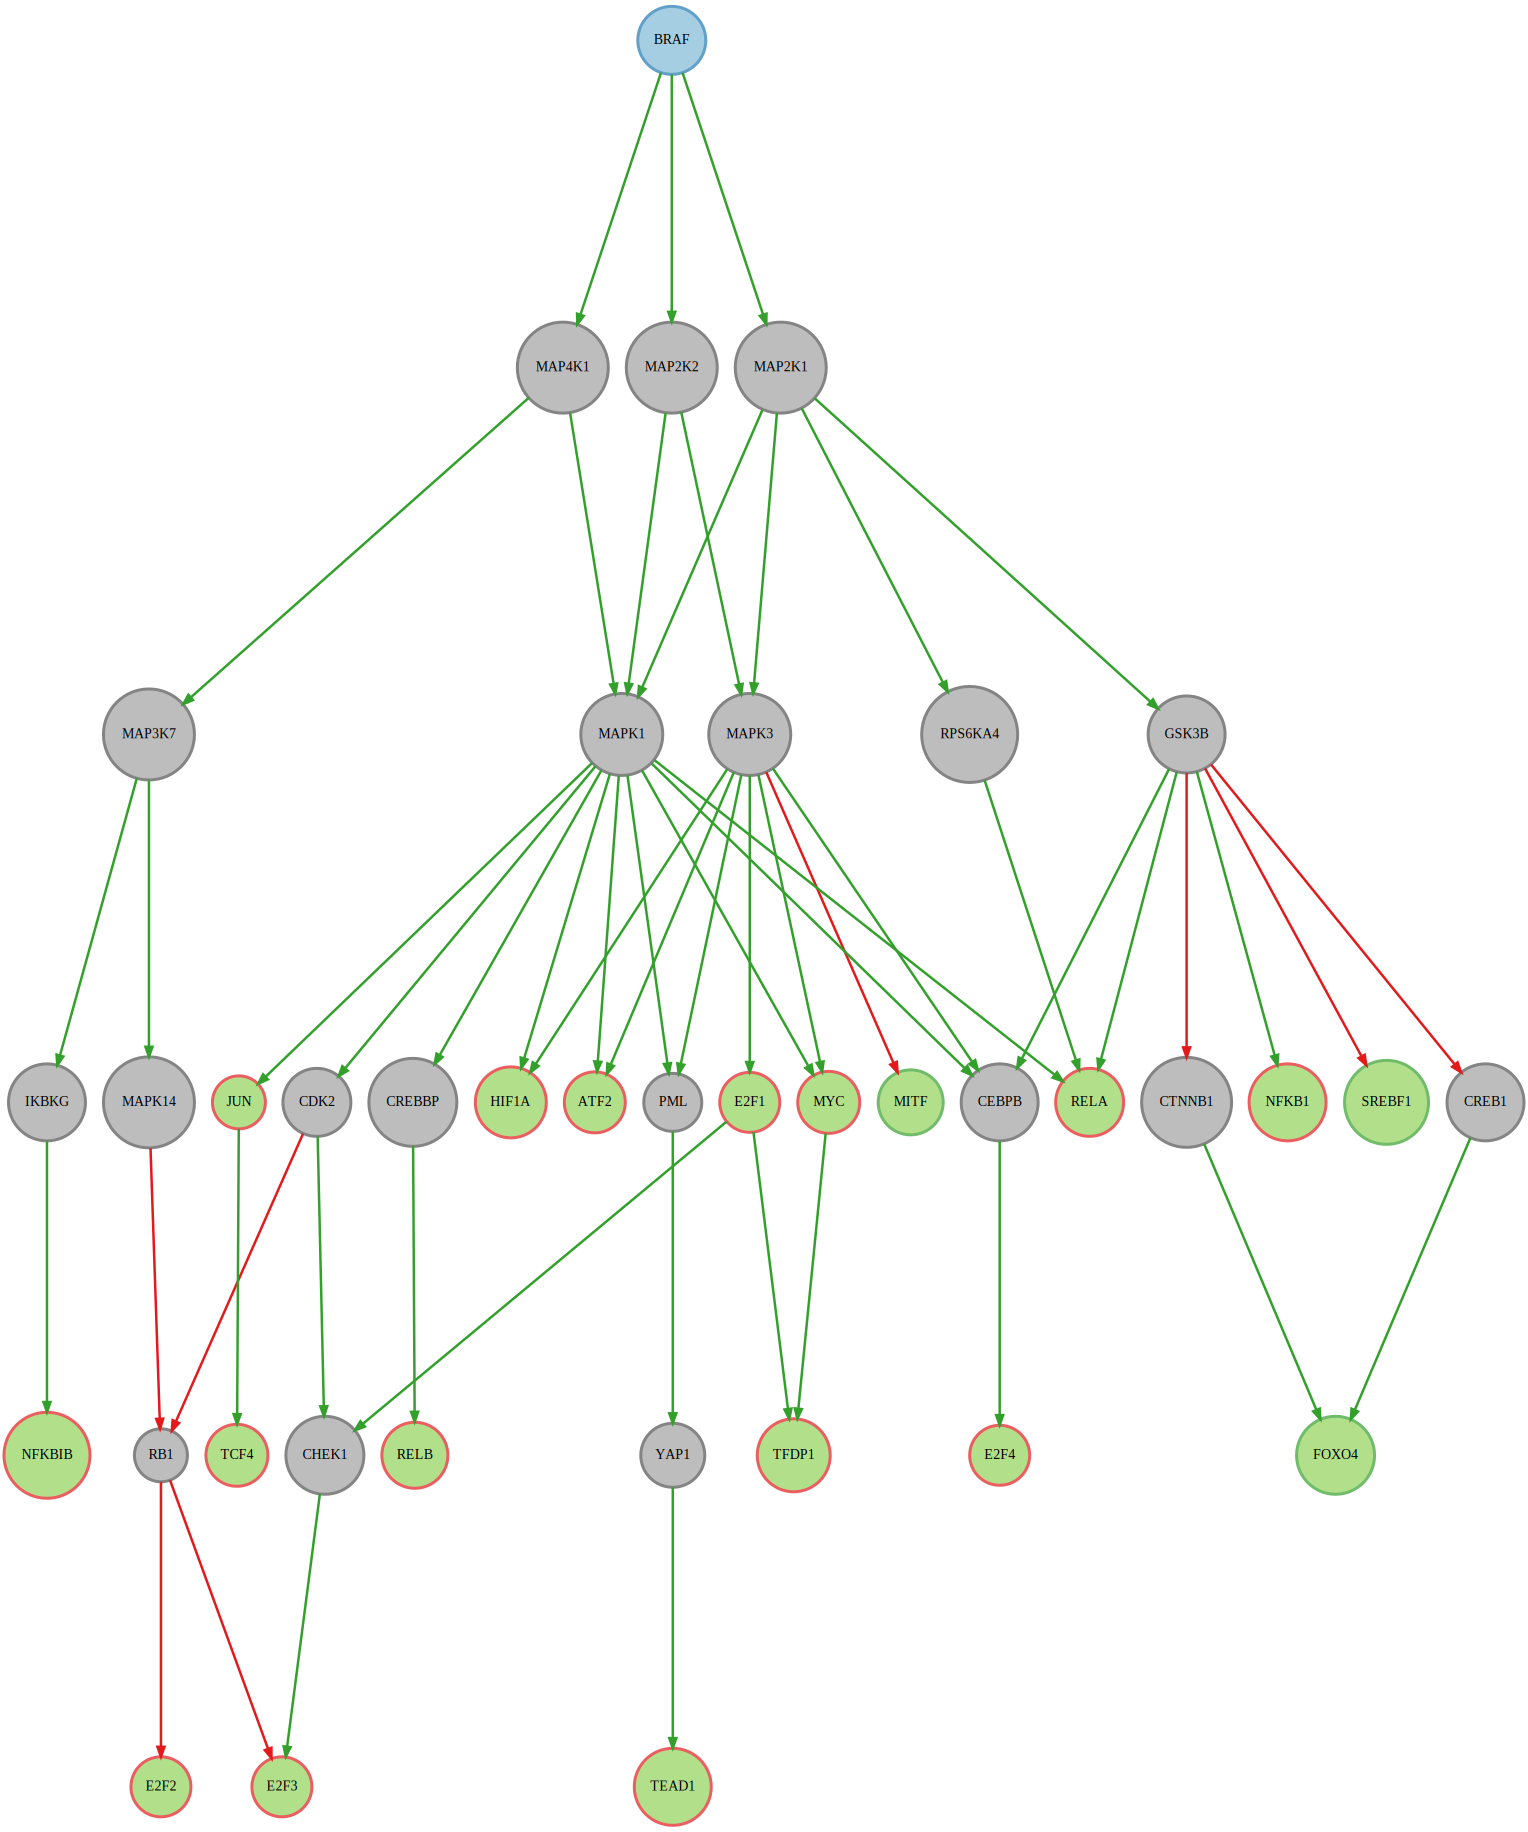

In [69]:
visualizer = nc.visual.NetworkXVisualizer(shortest_sc_network)
visualizer.visualize_network(source, measurements, network_type='sign_consistent')